<p style="text-align:center">
    <a href="https://www.linkedin.com/company/mt-learners/" target="_blank">
    <img src="https://github.com/Mr-MeerMoazzam/Mr-MeerMoazzam/blob/main/Untitled-2.jpg?raw=true" width="200" alt="MT Learners Logo"  />
    </a>
</p>


# Introduction to Keras 



Keras is an open-source neural network library written in Python that enables developers to easily design, build, and train deep learning models. It is a high-level API built on top of lower-level neural network libraries such as TensorFlow, Theano, and CNTK, providing a simpler and more intuitive way to create deep learning models. Keras allows users to quickly build and prototype deep learning models with minimal coding and provides a range of tools for implementing a variety of neural network architectures, such as convolutional neural networks (CNNs) and recurrent neural networks (RNNs). Additionally, Keras provides easy-to-use interfaces for data preprocessing, model evaluation, and visualization, making it an accessible tool for both beginners and experienced developers alike. With its user-friendly interface, flexibility, and wide range of applications, Keras has become a popular choice for implementing deep learning models in a variety of fields, including computer vision, natural language processing, and robotics.

## Using Keras to Build and Train Neural Networks


The purpose of this notebook is to employ a neural network to predict diabetes. To begin, we will establish a performance baseline by training a Random Forest model. Subsequently, we will use the Keras package to construct and train a neural network swiftly and evaluate its performance in comparison to the Random Forest model. Furthermore, we will investigate how diverse network structures influence performance, training time, and the degree of overfitting or underfitting.





## Diabetes Dataset

[Download Dataset](https://github.com/Mr-MeerMoazzam/Deep-Learning/blob/main/Keras%20Basics/diabetes.csv)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)


The Diabetes Dataset which has 8 numerical predictors and a binary outcome.


In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [78]:
## Import Keras objects for Deep Learning
from keras.models  import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

In [79]:
## Load in the data set 
names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", "skin_thickness", "insulin", 
         "bmi", "pedigree_function", "age", "has_diabetes"]
diabetes_df = pd.read_csv('./diabetes.csv', names=names, header=0)

In [80]:
# Take a peek at the data -- if there are lots of "NaN" you may have internet connectivity issues
print(diabetes_df.shape)
diabetes_df.sample(5)

(768, 9)


,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
202,0,108,68,20,0,27.3,0.787,32,0
101,1,151,60,0,0,26.1,0.179,22,0
128,1,117,88,24,145,34.5,0.403,40,1
547,4,131,68,21,166,33.1,0.160,28,0
678,3,121,52,0,0,36.0,0.127,25,1


In [81]:
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df["has_diabetes"].values

In [82]:
# Split the data to Train, and Test (75%, 25%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11111)

In [83]:
np.mean(y), np.mean(1-y)

(0.3489583333333333, 0.6510416666666666)

Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.
## Get a baseline performance using Random Forest
To begin, and get a baseline for classifier performance:
1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.


In [84]:
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [85]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)


print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.786
roc-auc is 0.835


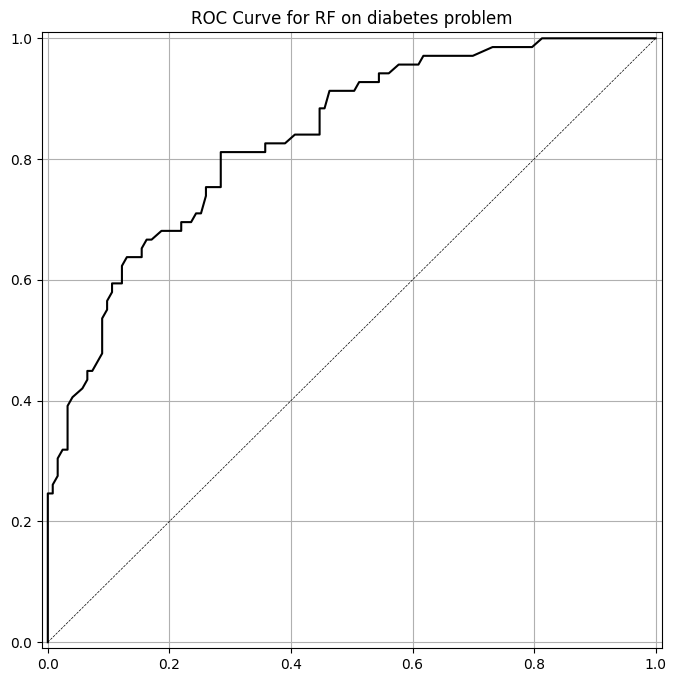

In [87]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])
plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')


## Build a Single Hidden Layer Neural Network

We will use the Sequential model to quickly build a neural network.  Our first network will be a single layer network.  We have 8 variables, so we set the input shape to 8.  Let's start by having a single hidden layer with 12 nodes.


In [61]:
## First let's normalize the data
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [88]:
# Define the Model 
# Input size is 8-dimensional
# 1 hidden layer, 12 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)

model_1 = Sequential()
model_1.add(Dense(12,input_shape = (8,),activation = 'sigmoid'))
model_1.add(Dense(1,activation='sigmoid'))

In [89]:
#  This is a nice tool to view the model you have created and count the parameters

model_1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 12)                108       
                                                                 
 dense_16 (Dense)            (None, 1)                 13        
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


Let's fit our model for 200 epochs.


In [96]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_1.compile(SGD(learning_rate = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=200)
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

Epoch 1/200
18/18 [==============================] - 0s 11ms/step - loss: 0.4865 - accuracy: 0.7708 - val_loss: 0.5082 - val_accuracy: 0.7708
Epoch 2/200
18/18 [==============================] - 0s 4ms/step - loss: 0.4863 - accuracy: 0.7708 - val_loss: 0.5081 - val_accuracy: 0.7708
Epoch 3/200
18/18 [==============================] - 0s 3ms/step - loss: 0.4862 - accuracy: 0.7708 - val_loss: 0.5080 - val_accuracy: 0.7708
Epoch 4/200
18/18 [==============================] - 0s 4ms/step - loss: 0.4861 - accuracy: 0.7708 - val_loss: 0.5078 - val_accuracy: 0.7708
Epoch 5/200
18/18 [==============================] - 0s 4ms/step - loss: 0.4860 - accuracy: 0.7743 - val_loss: 0.5077 - val_accuracy: 0.7708
Epoch 6/200
18/18 [==============================] - 0s 5ms/step - loss: 0.4858 - accuracy: 0.7726 - val_loss: 0.5076 - val_accuracy: 0.7708
Epoch 7/200
18/18 [==============================] - 0s 4ms/step - loss: 0.4857 - accuracy: 0.7726 - val_loss: 0.5075 - val_accuracy: 0.7708
Epoch 8/200


Epoch 59/200
18/18 [==============================] - 0s 3ms/step - loss: 0.4797 - accuracy: 0.7743 - val_loss: 0.5026 - val_accuracy: 0.7656
Epoch 60/200
18/18 [==============================] - 0s 4ms/step - loss: 0.4796 - accuracy: 0.7743 - val_loss: 0.5025 - val_accuracy: 0.7656
Epoch 61/200
18/18 [==============================] - 0s 4ms/step - loss: 0.4795 - accuracy: 0.7760 - val_loss: 0.5024 - val_accuracy: 0.7656
Epoch 62/200
18/18 [==============================] - 0s 4ms/step - loss: 0.4794 - accuracy: 0.7743 - val_loss: 0.5023 - val_accuracy: 0.7656
Epoch 63/200
18/18 [==============================] - 0s 4ms/step - loss: 0.4793 - accuracy: 0.7760 - val_loss: 0.5022 - val_accuracy: 0.7656
Epoch 64/200
18/18 [==============================] - 0s 4ms/step - loss: 0.4792 - accuracy: 0.7760 - val_loss: 0.5022 - val_accuracy: 0.7656
Epoch 65/200
18/18 [==============================] - 0s 4ms/step - loss: 0.4791 - accuracy: 0.7743 - val_loss: 0.5021 - val_accuracy: 0.7656
Epoch 

18/18 [==============================] - 0s 4ms/step - loss: 0.4747 - accuracy: 0.7778 - val_loss: 0.4986 - val_accuracy: 0.7604
Epoch 117/200
18/18 [==============================] - 0s 4ms/step - loss: 0.4746 - accuracy: 0.7778 - val_loss: 0.4986 - val_accuracy: 0.7604
Epoch 118/200
18/18 [==============================] - 0s 4ms/step - loss: 0.4745 - accuracy: 0.7778 - val_loss: 0.4985 - val_accuracy: 0.7604
Epoch 119/200
18/18 [==============================] - 0s 4ms/step - loss: 0.4744 - accuracy: 0.7778 - val_loss: 0.4985 - val_accuracy: 0.7604
Epoch 120/200
18/18 [==============================] - 0s 4ms/step - loss: 0.4744 - accuracy: 0.7778 - val_loss: 0.4984 - val_accuracy: 0.7604
Epoch 121/200
18/18 [==============================] - 0s 4ms/step - loss: 0.4743 - accuracy: 0.7778 - val_loss: 0.4984 - val_accuracy: 0.7604
Epoch 122/200
18/18 [==============================] - 0s 4ms/step - loss: 0.4742 - accuracy: 0.7795 - val_loss: 0.4983 - val_accuracy: 0.7604
Epoch 123/200

18/18 [==============================] - 0s 4ms/step - loss: 0.4709 - accuracy: 0.7795 - val_loss: 0.4959 - val_accuracy: 0.7604
Epoch 174/200
18/18 [==============================] - 0s 4ms/step - loss: 0.4708 - accuracy: 0.7795 - val_loss: 0.4958 - val_accuracy: 0.7604
Epoch 175/200
18/18 [==============================] - 0s 4ms/step - loss: 0.4708 - accuracy: 0.7795 - val_loss: 0.4958 - val_accuracy: 0.7604
Epoch 176/200
18/18 [==============================] - 0s 4ms/step - loss: 0.4707 - accuracy: 0.7795 - val_loss: 0.4957 - val_accuracy: 0.7604
Epoch 177/200
18/18 [==============================] - 0s 4ms/step - loss: 0.4706 - accuracy: 0.7795 - val_loss: 0.4957 - val_accuracy: 0.7604
Epoch 178/200
18/18 [==============================] - 0s 4ms/step - loss: 0.4706 - accuracy: 0.7812 - val_loss: 0.4957 - val_accuracy: 0.7604
Epoch 179/200
18/18 [==============================] - 0s 4ms/step - loss: 0.4705 - accuracy: 0.7795 - val_loss: 0.4956 - val_accuracy: 0.7552
Epoch 180/200

In [97]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.
# Assuming your model is defined as `model_1`

# Make predictions on test data
y_pred_prob_nn_1 = model_1.predict(X_test_norm)

# Obtain predicted class labels by taking the index of the highest probability for each example
y_pred_class_nn_1 = y_pred_prob_nn_1.argmax(axis=-1)


6/6 [==============================] - 0s 2ms/step


In [98]:
y_pred_prob_nn_1[:10]

array([[0.48891714],
       [0.7093221 ],
       [0.2787088 ],
       [0.26989993],
       [0.19304611],
       [0.514679  ],
       [0.08812507],
       [0.31525382],
       [0.8304369 ],
       [0.19541515]], dtype=float32)

In [99]:
y_pred_class_nn_1[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

accuracy is 0.641
roc-auc is 0.821


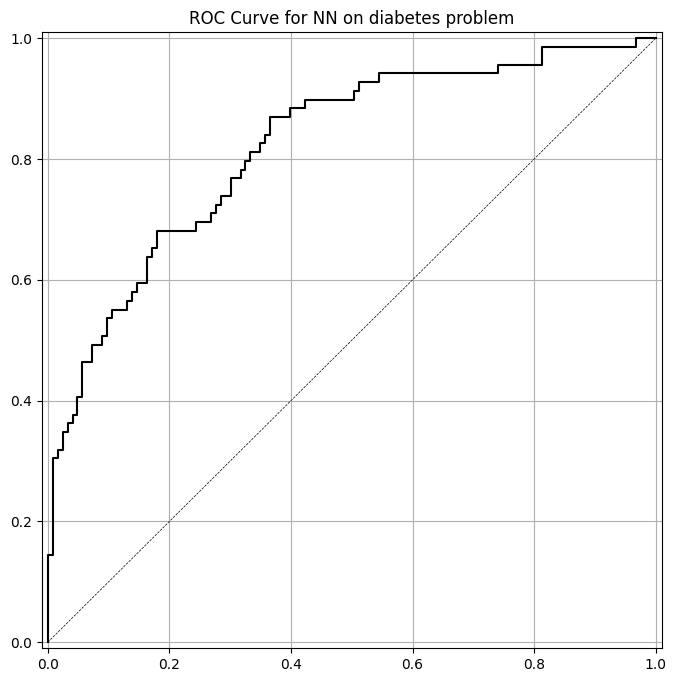

In [100]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.


In [101]:
run_hist_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.


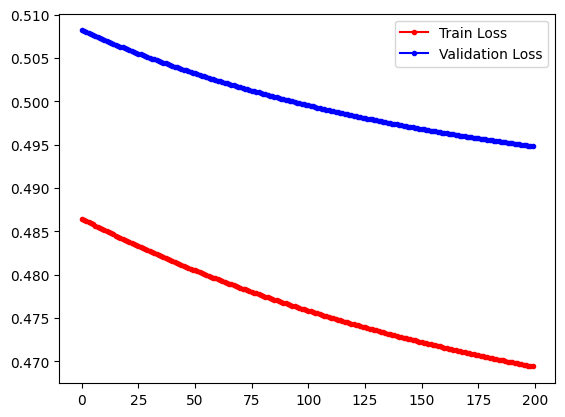

In [102]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

Looks like the losses are still going down on both the training set and the validation set.  This suggests that the model might benefit from further training.  Let's train the model a little more and see what happens. Note that it will pick up from where it left off. Train for 1000 more epochs.


In [103]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000)

Epoch 1/1000
18/18 [==============================] - 0s 6ms/step - loss: 0.4694 - accuracy: 0.7830 - val_loss: 0.4948 - val_accuracy: 0.7552
Epoch 2/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4693 - accuracy: 0.7830 - val_loss: 0.4948 - val_accuracy: 0.7552
Epoch 3/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4693 - accuracy: 0.7830 - val_loss: 0.4947 - val_accuracy: 0.7552
Epoch 4/1000
18/18 [==============================] - 0s 5ms/step - loss: 0.4692 - accuracy: 0.7830 - val_loss: 0.4947 - val_accuracy: 0.7552
Epoch 5/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4692 - accuracy: 0.7830 - val_loss: 0.4947 - val_accuracy: 0.7552
Epoch 6/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4691 - accuracy: 0.7830 - val_loss: 0.4946 - val_accuracy: 0.7552
Epoch 7/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4691 - accuracy: 0.7830 - val_loss: 0.4946 - val_accuracy: 0.7552
Epoch 

18/18 [==============================] - 0s 4ms/step - loss: 0.4668 - accuracy: 0.7812 - val_loss: 0.4931 - val_accuracy: 0.7552
Epoch 59/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4668 - accuracy: 0.7812 - val_loss: 0.4931 - val_accuracy: 0.7552
Epoch 60/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4667 - accuracy: 0.7812 - val_loss: 0.4931 - val_accuracy: 0.7552
Epoch 61/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4667 - accuracy: 0.7812 - val_loss: 0.4930 - val_accuracy: 0.7552
Epoch 62/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4667 - accuracy: 0.7812 - val_loss: 0.4930 - val_accuracy: 0.7552
Epoch 63/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4666 - accuracy: 0.7812 - val_loss: 0.4930 - val_accuracy: 0.7552
Epoch 64/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4666 - accuracy: 0.7812 - val_loss: 0.4930 - val_accuracy: 0.7552
Epoch 65/1000

18/18 [==============================] - 0s 4ms/step - loss: 0.4648 - accuracy: 0.7812 - val_loss: 0.4919 - val_accuracy: 0.7552
Epoch 116/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4648 - accuracy: 0.7812 - val_loss: 0.4919 - val_accuracy: 0.7552
Epoch 117/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4648 - accuracy: 0.7812 - val_loss: 0.4919 - val_accuracy: 0.7552
Epoch 118/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4647 - accuracy: 0.7812 - val_loss: 0.4919 - val_accuracy: 0.7552
Epoch 119/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4647 - accuracy: 0.7812 - val_loss: 0.4918 - val_accuracy: 0.7552
Epoch 120/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4647 - accuracy: 0.7812 - val_loss: 0.4918 - val_accuracy: 0.7552
Epoch 121/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4647 - accuracy: 0.7812 - val_loss: 0.4918 - val_accuracy: 0.7552
Epoch 1

Epoch 172/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4633 - accuracy: 0.7812 - val_loss: 0.4911 - val_accuracy: 0.7552
Epoch 173/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4633 - accuracy: 0.7812 - val_loss: 0.4910 - val_accuracy: 0.7552
Epoch 174/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4632 - accuracy: 0.7812 - val_loss: 0.4910 - val_accuracy: 0.7552
Epoch 175/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4632 - accuracy: 0.7812 - val_loss: 0.4910 - val_accuracy: 0.7552
Epoch 176/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4632 - accuracy: 0.7830 - val_loss: 0.4910 - val_accuracy: 0.7552
Epoch 177/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4631 - accuracy: 0.7830 - val_loss: 0.4910 - val_accuracy: 0.7552
Epoch 178/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4631 - accuracy: 0.7830 - val_loss: 0.4910 - val_accuracy:

Epoch 229/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4620 - accuracy: 0.7847 - val_loss: 0.4904 - val_accuracy: 0.7552
Epoch 230/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4620 - accuracy: 0.7847 - val_loss: 0.4904 - val_accuracy: 0.7552
Epoch 231/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4620 - accuracy: 0.7847 - val_loss: 0.4904 - val_accuracy: 0.7552
Epoch 232/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4620 - accuracy: 0.7847 - val_loss: 0.4904 - val_accuracy: 0.7552
Epoch 233/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4619 - accuracy: 0.7847 - val_loss: 0.4904 - val_accuracy: 0.7552
Epoch 234/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4619 - accuracy: 0.7847 - val_loss: 0.4904 - val_accuracy: 0.7552
Epoch 235/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4619 - accuracy: 0.7847 - val_loss: 0.4904 - val_accuracy:

Epoch 286/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4610 - accuracy: 0.7847 - val_loss: 0.4900 - val_accuracy: 0.7552
Epoch 287/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4610 - accuracy: 0.7847 - val_loss: 0.4900 - val_accuracy: 0.7552
Epoch 288/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4610 - accuracy: 0.7847 - val_loss: 0.4900 - val_accuracy: 0.7552
Epoch 289/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4610 - accuracy: 0.7847 - val_loss: 0.4900 - val_accuracy: 0.7552
Epoch 290/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4609 - accuracy: 0.7847 - val_loss: 0.4900 - val_accuracy: 0.7552
Epoch 291/1000
18/18 [==============================] - 0s 5ms/step - loss: 0.4609 - accuracy: 0.7830 - val_loss: 0.4900 - val_accuracy: 0.7552
Epoch 292/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4609 - accuracy: 0.7847 - val_loss: 0.4900 - val_accuracy:

Epoch 343/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4602 - accuracy: 0.7830 - val_loss: 0.4897 - val_accuracy: 0.7552
Epoch 344/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4602 - accuracy: 0.7830 - val_loss: 0.4897 - val_accuracy: 0.7552
Epoch 345/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4602 - accuracy: 0.7830 - val_loss: 0.4897 - val_accuracy: 0.7604
Epoch 346/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4601 - accuracy: 0.7830 - val_loss: 0.4897 - val_accuracy: 0.7604
Epoch 347/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4601 - accuracy: 0.7830 - val_loss: 0.4897 - val_accuracy: 0.7604
Epoch 348/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4601 - accuracy: 0.7830 - val_loss: 0.4897 - val_accuracy: 0.7604
Epoch 349/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4601 - accuracy: 0.7830 - val_loss: 0.4897 - val_accuracy:

Epoch 400/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4595 - accuracy: 0.7830 - val_loss: 0.4895 - val_accuracy: 0.7604
Epoch 401/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4595 - accuracy: 0.7830 - val_loss: 0.4895 - val_accuracy: 0.7604
Epoch 402/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4595 - accuracy: 0.7830 - val_loss: 0.4895 - val_accuracy: 0.7604
Epoch 403/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4595 - accuracy: 0.7830 - val_loss: 0.4895 - val_accuracy: 0.7604
Epoch 404/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4595 - accuracy: 0.7830 - val_loss: 0.4895 - val_accuracy: 0.7604
Epoch 405/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4594 - accuracy: 0.7830 - val_loss: 0.4895 - val_accuracy: 0.7604
Epoch 406/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4594 - accuracy: 0.7830 - val_loss: 0.4895 - val_accuracy:

Epoch 457/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4589 - accuracy: 0.7830 - val_loss: 0.4893 - val_accuracy: 0.7656
Epoch 458/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4589 - accuracy: 0.7830 - val_loss: 0.4893 - val_accuracy: 0.7656
Epoch 459/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4589 - accuracy: 0.7830 - val_loss: 0.4893 - val_accuracy: 0.7656
Epoch 460/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4589 - accuracy: 0.7830 - val_loss: 0.4893 - val_accuracy: 0.7656
Epoch 461/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4589 - accuracy: 0.7830 - val_loss: 0.4893 - val_accuracy: 0.7656
Epoch 462/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4589 - accuracy: 0.7830 - val_loss: 0.4893 - val_accuracy: 0.7656
Epoch 463/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4589 - accuracy: 0.7830 - val_loss: 0.4893 - val_accuracy:

Epoch 514/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4584 - accuracy: 0.7830 - val_loss: 0.4893 - val_accuracy: 0.7656
Epoch 515/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4584 - accuracy: 0.7830 - val_loss: 0.4893 - val_accuracy: 0.7656
Epoch 516/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4584 - accuracy: 0.7830 - val_loss: 0.4893 - val_accuracy: 0.7656
Epoch 517/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4584 - accuracy: 0.7830 - val_loss: 0.4893 - val_accuracy: 0.7656
Epoch 518/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4584 - accuracy: 0.7830 - val_loss: 0.4893 - val_accuracy: 0.7656
Epoch 519/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4584 - accuracy: 0.7830 - val_loss: 0.4893 - val_accuracy: 0.7656
Epoch 520/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4584 - accuracy: 0.7830 - val_loss: 0.4893 - val_accuracy:

Epoch 571/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4580 - accuracy: 0.7830 - val_loss: 0.4892 - val_accuracy: 0.7604
Epoch 572/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4580 - accuracy: 0.7830 - val_loss: 0.4892 - val_accuracy: 0.7604
Epoch 573/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4580 - accuracy: 0.7830 - val_loss: 0.4892 - val_accuracy: 0.7604
Epoch 574/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4580 - accuracy: 0.7830 - val_loss: 0.4892 - val_accuracy: 0.7604
Epoch 575/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4580 - accuracy: 0.7830 - val_loss: 0.4892 - val_accuracy: 0.7604
Epoch 576/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4579 - accuracy: 0.7830 - val_loss: 0.4892 - val_accuracy: 0.7604
Epoch 577/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4579 - accuracy: 0.7830 - val_loss: 0.4892 - val_accuracy:

Epoch 628/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4576 - accuracy: 0.7812 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 629/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4576 - accuracy: 0.7812 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 630/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4576 - accuracy: 0.7812 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 631/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4576 - accuracy: 0.7812 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 632/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4576 - accuracy: 0.7812 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 633/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4576 - accuracy: 0.7830 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 634/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4576 - accuracy: 0.7812 - val_loss: 0.4892 - val_accuracy:

Epoch 685/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4573 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 686/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4573 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 687/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4573 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 688/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4573 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 689/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4573 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 690/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4573 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 691/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4572 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy:

Epoch 742/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4570 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 743/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4570 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 744/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4570 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 745/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4569 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 746/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4570 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 747/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4569 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 748/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4569 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy:

Epoch 799/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4567 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 800/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4567 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 801/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4566 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 802/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4567 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 803/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4567 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 804/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4567 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 805/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4567 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy:

Epoch 856/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4564 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 857/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4564 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 858/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4564 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 859/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4564 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 860/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4564 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 861/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4564 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 862/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4564 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy:

Epoch 913/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4562 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 914/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4562 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 915/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4561 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 916/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4562 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 917/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4561 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 918/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4561 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy: 0.7656
Epoch 919/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4561 - accuracy: 0.7795 - val_loss: 0.4892 - val_accuracy:

Epoch 970/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4559 - accuracy: 0.7812 - val_loss: 0.4892 - val_accuracy: 0.7708
Epoch 971/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4559 - accuracy: 0.7812 - val_loss: 0.4892 - val_accuracy: 0.7708
Epoch 972/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4559 - accuracy: 0.7812 - val_loss: 0.4892 - val_accuracy: 0.7708
Epoch 973/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4559 - accuracy: 0.7812 - val_loss: 0.4892 - val_accuracy: 0.7708
Epoch 974/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4559 - accuracy: 0.7812 - val_loss: 0.4892 - val_accuracy: 0.7708
Epoch 975/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4559 - accuracy: 0.7812 - val_loss: 0.4892 - val_accuracy: 0.7708
Epoch 976/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4559 - accuracy: 0.7812 - val_loss: 0.4892 - val_accuracy:

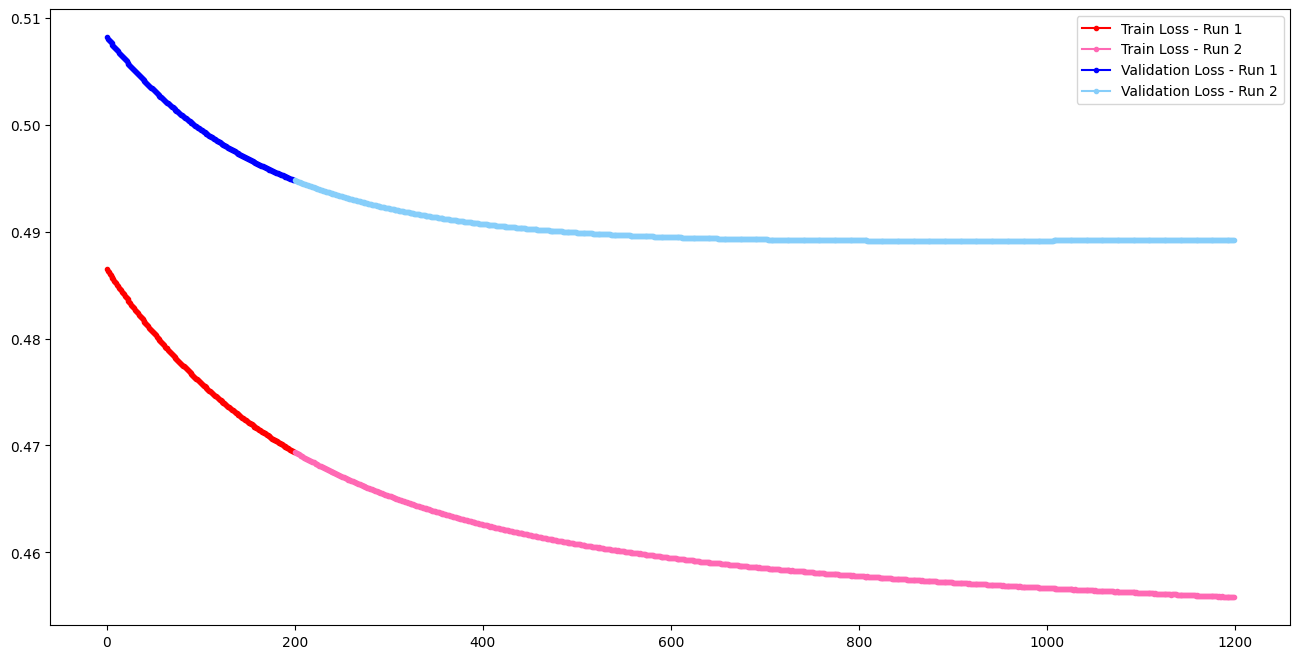

In [104]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Note that this graph begins where the other left off.  While the training loss is still going down, it looks like the validation loss has stabilized (or even gotten worse!).  This suggests that our network will not benefit from further training.  What is the appropriate number of epochs?


## Rebuild Neural Network 
For this, do the following in the cells below:
- Build a model with two hidden layers, each with 6 nodes
- Use the "relu" activation function for the hidden layers, and "sigmoid" for the final layer
- Use a learning rate of .003 and train for 1500 epochs
- Graph the trajectory of the loss functions, accuracy on both train and test set
- Plot the roc curve for the predictions

Experiment with different learning rates, numbers of epochs, and network structures


In [106]:

model_2 = Sequential()
model_2.add(Dense(6, input_shape=(8,), activation="relu"))
model_2.add(Dense(6,  activation="relu"))
model_2.add(Dense(1, activation="sigmoid"))

model_2.compile(SGD(learning_rate = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_2 = model_2.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1500)

Epoch 1/1500
18/18 [==============================] - 1s 11ms/step - loss: 0.9109 - accuracy: 0.3767 - val_loss: 0.9485 - val_accuracy: 0.3646
Epoch 2/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.8947 - accuracy: 0.3819 - val_loss: 0.9308 - val_accuracy: 0.3698
Epoch 3/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.8798 - accuracy: 0.3819 - val_loss: 0.9147 - val_accuracy: 0.3802
Epoch 4/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.8662 - accuracy: 0.3924 - val_loss: 0.8999 - val_accuracy: 0.3802
Epoch 5/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.8538 - accuracy: 0.3958 - val_loss: 0.8864 - val_accuracy: 0.4010
Epoch 6/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.8424 - accuracy: 0.4062 - val_loss: 0.8739 - val_accuracy: 0.4062
Epoch 7/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.8319 - accuracy: 0.4149 - val_loss: 0.8623 - val_accuracy: 0.4115
Epoch

18/18 [==============================] - 0s 4ms/step - loss: 0.6464 - accuracy: 0.7014 - val_loss: 0.6541 - val_accuracy: 0.6615
Epoch 59/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.6449 - accuracy: 0.6979 - val_loss: 0.6524 - val_accuracy: 0.6615
Epoch 60/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.6435 - accuracy: 0.7014 - val_loss: 0.6507 - val_accuracy: 0.6562
Epoch 61/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.6420 - accuracy: 0.7014 - val_loss: 0.6491 - val_accuracy: 0.6719
Epoch 62/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.6407 - accuracy: 0.7031 - val_loss: 0.6474 - val_accuracy: 0.6771
Epoch 63/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.6393 - accuracy: 0.7083 - val_loss: 0.6458 - val_accuracy: 0.6823
Epoch 64/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.6379 - accuracy: 0.7066 - val_loss: 0.6442 - val_accuracy: 0.6771
Epoch 65/1500

18/18 [==============================] - 0s 4ms/step - loss: 0.5880 - accuracy: 0.7483 - val_loss: 0.5870 - val_accuracy: 0.7240
Epoch 116/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5873 - accuracy: 0.7500 - val_loss: 0.5862 - val_accuracy: 0.7240
Epoch 117/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5866 - accuracy: 0.7483 - val_loss: 0.5854 - val_accuracy: 0.7240
Epoch 118/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5859 - accuracy: 0.7483 - val_loss: 0.5846 - val_accuracy: 0.7240
Epoch 119/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5852 - accuracy: 0.7483 - val_loss: 0.5838 - val_accuracy: 0.7240
Epoch 120/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5844 - accuracy: 0.7483 - val_loss: 0.5830 - val_accuracy: 0.7240
Epoch 121/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5838 - accuracy: 0.7465 - val_loss: 0.5822 - val_accuracy: 0.7292
Epoch 1

Epoch 172/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5551 - accuracy: 0.7622 - val_loss: 0.5528 - val_accuracy: 0.7240
Epoch 173/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5546 - accuracy: 0.7622 - val_loss: 0.5524 - val_accuracy: 0.7240
Epoch 174/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5542 - accuracy: 0.7622 - val_loss: 0.5520 - val_accuracy: 0.7240
Epoch 175/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5537 - accuracy: 0.7622 - val_loss: 0.5516 - val_accuracy: 0.7240
Epoch 176/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5532 - accuracy: 0.7622 - val_loss: 0.5512 - val_accuracy: 0.7240
Epoch 177/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5528 - accuracy: 0.7622 - val_loss: 0.5507 - val_accuracy: 0.7240
Epoch 178/1500
18/18 [==============================] - 0s 5ms/step - loss: 0.5523 - accuracy: 0.7604 - val_loss: 0.5503 - val_accuracy:

Epoch 229/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5336 - accuracy: 0.7691 - val_loss: 0.5348 - val_accuracy: 0.7500
Epoch 230/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5333 - accuracy: 0.7691 - val_loss: 0.5346 - val_accuracy: 0.7500
Epoch 231/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5330 - accuracy: 0.7691 - val_loss: 0.5344 - val_accuracy: 0.7500
Epoch 232/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5327 - accuracy: 0.7674 - val_loss: 0.5341 - val_accuracy: 0.7500
Epoch 233/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5324 - accuracy: 0.7691 - val_loss: 0.5339 - val_accuracy: 0.7500
Epoch 234/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5321 - accuracy: 0.7691 - val_loss: 0.5337 - val_accuracy: 0.7500
Epoch 235/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5318 - accuracy: 0.7691 - val_loss: 0.5334 - val_accuracy:

Epoch 286/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5179 - accuracy: 0.7674 - val_loss: 0.5245 - val_accuracy: 0.7448
Epoch 287/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5177 - accuracy: 0.7691 - val_loss: 0.5244 - val_accuracy: 0.7448
Epoch 288/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5174 - accuracy: 0.7674 - val_loss: 0.5243 - val_accuracy: 0.7448
Epoch 289/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5172 - accuracy: 0.7691 - val_loss: 0.5241 - val_accuracy: 0.7448
Epoch 290/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5169 - accuracy: 0.7674 - val_loss: 0.5240 - val_accuracy: 0.7448
Epoch 291/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5166 - accuracy: 0.7691 - val_loss: 0.5239 - val_accuracy: 0.7448
Epoch 292/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5165 - accuracy: 0.7691 - val_loss: 0.5237 - val_accuracy:

Epoch 343/1500
18/18 [==============================] - 0s 5ms/step - loss: 0.5058 - accuracy: 0.7778 - val_loss: 0.5189 - val_accuracy: 0.7500
Epoch 344/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5054 - accuracy: 0.7778 - val_loss: 0.5189 - val_accuracy: 0.7500
Epoch 345/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5053 - accuracy: 0.7778 - val_loss: 0.5188 - val_accuracy: 0.7500
Epoch 346/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5050 - accuracy: 0.7778 - val_loss: 0.5187 - val_accuracy: 0.7500
Epoch 347/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5048 - accuracy: 0.7778 - val_loss: 0.5186 - val_accuracy: 0.7500
Epoch 348/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5047 - accuracy: 0.7778 - val_loss: 0.5186 - val_accuracy: 0.7500
Epoch 349/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5045 - accuracy: 0.7726 - val_loss: 0.5185 - val_accuracy:

Epoch 400/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4960 - accuracy: 0.7743 - val_loss: 0.5157 - val_accuracy: 0.7708
Epoch 401/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4958 - accuracy: 0.7743 - val_loss: 0.5156 - val_accuracy: 0.7708
Epoch 402/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4958 - accuracy: 0.7743 - val_loss: 0.5156 - val_accuracy: 0.7708
Epoch 403/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4955 - accuracy: 0.7743 - val_loss: 0.5155 - val_accuracy: 0.7708
Epoch 404/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4954 - accuracy: 0.7743 - val_loss: 0.5155 - val_accuracy: 0.7708
Epoch 405/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4954 - accuracy: 0.7743 - val_loss: 0.5155 - val_accuracy: 0.7708
Epoch 406/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4952 - accuracy: 0.7743 - val_loss: 0.5154 - val_accuracy:

Epoch 457/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4889 - accuracy: 0.7743 - val_loss: 0.5139 - val_accuracy: 0.7552
Epoch 458/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4888 - accuracy: 0.7760 - val_loss: 0.5139 - val_accuracy: 0.7552
Epoch 459/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4886 - accuracy: 0.7760 - val_loss: 0.5139 - val_accuracy: 0.7552
Epoch 460/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4886 - accuracy: 0.7760 - val_loss: 0.5139 - val_accuracy: 0.7552
Epoch 461/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4885 - accuracy: 0.7743 - val_loss: 0.5139 - val_accuracy: 0.7552
Epoch 462/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4883 - accuracy: 0.7760 - val_loss: 0.5138 - val_accuracy: 0.7552
Epoch 463/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4883 - accuracy: 0.7743 - val_loss: 0.5138 - val_accuracy:

Epoch 514/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4835 - accuracy: 0.7778 - val_loss: 0.5131 - val_accuracy: 0.7552
Epoch 515/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4834 - accuracy: 0.7778 - val_loss: 0.5131 - val_accuracy: 0.7552
Epoch 516/1500
18/18 [==============================] - 0s 5ms/step - loss: 0.4834 - accuracy: 0.7778 - val_loss: 0.5130 - val_accuracy: 0.7552
Epoch 517/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4833 - accuracy: 0.7778 - val_loss: 0.5130 - val_accuracy: 0.7552
Epoch 518/1500
18/18 [==============================] - 0s 5ms/step - loss: 0.4831 - accuracy: 0.7778 - val_loss: 0.5130 - val_accuracy: 0.7552
Epoch 519/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4831 - accuracy: 0.7778 - val_loss: 0.5130 - val_accuracy: 0.7552
Epoch 520/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4830 - accuracy: 0.7778 - val_loss: 0.5129 - val_accuracy:

Epoch 571/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4789 - accuracy: 0.7795 - val_loss: 0.5125 - val_accuracy: 0.7604
Epoch 572/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4789 - accuracy: 0.7830 - val_loss: 0.5125 - val_accuracy: 0.7604
Epoch 573/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4789 - accuracy: 0.7795 - val_loss: 0.5125 - val_accuracy: 0.7604
Epoch 574/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4789 - accuracy: 0.7830 - val_loss: 0.5125 - val_accuracy: 0.7604
Epoch 575/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4786 - accuracy: 0.7812 - val_loss: 0.5125 - val_accuracy: 0.7604
Epoch 576/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4787 - accuracy: 0.7778 - val_loss: 0.5124 - val_accuracy: 0.7604
Epoch 577/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4786 - accuracy: 0.7795 - val_loss: 0.5124 - val_accuracy:

Epoch 628/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4752 - accuracy: 0.7812 - val_loss: 0.5121 - val_accuracy: 0.7552
Epoch 629/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4751 - accuracy: 0.7812 - val_loss: 0.5120 - val_accuracy: 0.7552
Epoch 630/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4751 - accuracy: 0.7812 - val_loss: 0.5120 - val_accuracy: 0.7552
Epoch 631/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4750 - accuracy: 0.7812 - val_loss: 0.5120 - val_accuracy: 0.7552
Epoch 632/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4750 - accuracy: 0.7812 - val_loss: 0.5120 - val_accuracy: 0.7552
Epoch 633/1500
18/18 [==============================] - 0s 5ms/step - loss: 0.4749 - accuracy: 0.7830 - val_loss: 0.5120 - val_accuracy: 0.7552
Epoch 634/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4749 - accuracy: 0.7830 - val_loss: 0.5120 - val_accuracy:

Epoch 685/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4723 - accuracy: 0.7830 - val_loss: 0.5114 - val_accuracy: 0.7500
Epoch 686/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4722 - accuracy: 0.7847 - val_loss: 0.5114 - val_accuracy: 0.7500
Epoch 687/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4722 - accuracy: 0.7847 - val_loss: 0.5113 - val_accuracy: 0.7500
Epoch 688/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4722 - accuracy: 0.7865 - val_loss: 0.5113 - val_accuracy: 0.7500
Epoch 689/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4721 - accuracy: 0.7847 - val_loss: 0.5113 - val_accuracy: 0.7500
Epoch 690/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4721 - accuracy: 0.7847 - val_loss: 0.5113 - val_accuracy: 0.7500
Epoch 691/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4720 - accuracy: 0.7847 - val_loss: 0.5113 - val_accuracy:

Epoch 742/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4695 - accuracy: 0.7847 - val_loss: 0.5103 - val_accuracy: 0.7448
Epoch 743/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4696 - accuracy: 0.7865 - val_loss: 0.5102 - val_accuracy: 0.7448
Epoch 744/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4696 - accuracy: 0.7865 - val_loss: 0.5102 - val_accuracy: 0.7448
Epoch 745/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4694 - accuracy: 0.7865 - val_loss: 0.5101 - val_accuracy: 0.7448
Epoch 746/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4694 - accuracy: 0.7847 - val_loss: 0.5100 - val_accuracy: 0.7448
Epoch 747/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4692 - accuracy: 0.7830 - val_loss: 0.5100 - val_accuracy: 0.7448
Epoch 748/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4693 - accuracy: 0.7847 - val_loss: 0.5100 - val_accuracy:

Epoch 799/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4670 - accuracy: 0.7830 - val_loss: 0.5094 - val_accuracy: 0.7344
Epoch 800/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4671 - accuracy: 0.7847 - val_loss: 0.5095 - val_accuracy: 0.7344
Epoch 801/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4671 - accuracy: 0.7830 - val_loss: 0.5094 - val_accuracy: 0.7344
Epoch 802/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4670 - accuracy: 0.7847 - val_loss: 0.5094 - val_accuracy: 0.7344
Epoch 803/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4669 - accuracy: 0.7830 - val_loss: 0.5094 - val_accuracy: 0.7344
Epoch 804/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4669 - accuracy: 0.7847 - val_loss: 0.5094 - val_accuracy: 0.7344
Epoch 805/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4669 - accuracy: 0.7847 - val_loss: 0.5094 - val_accuracy:

Epoch 856/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4650 - accuracy: 0.7830 - val_loss: 0.5087 - val_accuracy: 0.7344
Epoch 857/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4649 - accuracy: 0.7847 - val_loss: 0.5087 - val_accuracy: 0.7344
Epoch 858/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4648 - accuracy: 0.7865 - val_loss: 0.5086 - val_accuracy: 0.7344
Epoch 859/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4648 - accuracy: 0.7847 - val_loss: 0.5086 - val_accuracy: 0.7344
Epoch 860/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4648 - accuracy: 0.7830 - val_loss: 0.5086 - val_accuracy: 0.7344
Epoch 861/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4648 - accuracy: 0.7865 - val_loss: 0.5086 - val_accuracy: 0.7344
Epoch 862/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4647 - accuracy: 0.7865 - val_loss: 0.5086 - val_accuracy:

Epoch 913/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4632 - accuracy: 0.7882 - val_loss: 0.5083 - val_accuracy: 0.7344
Epoch 914/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4630 - accuracy: 0.7882 - val_loss: 0.5083 - val_accuracy: 0.7344
Epoch 915/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4630 - accuracy: 0.7865 - val_loss: 0.5083 - val_accuracy: 0.7344
Epoch 916/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4629 - accuracy: 0.7882 - val_loss: 0.5083 - val_accuracy: 0.7344
Epoch 917/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4629 - accuracy: 0.7882 - val_loss: 0.5083 - val_accuracy: 0.7344
Epoch 918/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4629 - accuracy: 0.7865 - val_loss: 0.5083 - val_accuracy: 0.7344
Epoch 919/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4629 - accuracy: 0.7865 - val_loss: 0.5083 - val_accuracy:

Epoch 970/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4615 - accuracy: 0.7865 - val_loss: 0.5084 - val_accuracy: 0.7292
Epoch 971/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4615 - accuracy: 0.7847 - val_loss: 0.5084 - val_accuracy: 0.7292
Epoch 972/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4614 - accuracy: 0.7865 - val_loss: 0.5085 - val_accuracy: 0.7292
Epoch 973/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4614 - accuracy: 0.7865 - val_loss: 0.5085 - val_accuracy: 0.7292
Epoch 974/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4614 - accuracy: 0.7847 - val_loss: 0.5085 - val_accuracy: 0.7292
Epoch 975/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4613 - accuracy: 0.7882 - val_loss: 0.5086 - val_accuracy: 0.7292
Epoch 976/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4614 - accuracy: 0.7865 - val_loss: 0.5085 - val_accuracy:

Epoch 1027/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4600 - accuracy: 0.7865 - val_loss: 0.5088 - val_accuracy: 0.7292
Epoch 1028/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4600 - accuracy: 0.7882 - val_loss: 0.5089 - val_accuracy: 0.7292
Epoch 1029/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4599 - accuracy: 0.7882 - val_loss: 0.5089 - val_accuracy: 0.7292
Epoch 1030/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4599 - accuracy: 0.7865 - val_loss: 0.5089 - val_accuracy: 0.7292
Epoch 1031/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4599 - accuracy: 0.7882 - val_loss: 0.5089 - val_accuracy: 0.7292
Epoch 1032/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4599 - accuracy: 0.7847 - val_loss: 0.5089 - val_accuracy: 0.7292
Epoch 1033/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4600 - accuracy: 0.7865 - val_loss: 0.5088 - val_ac

18/18 [==============================] - 0s 3ms/step - loss: 0.4587 - accuracy: 0.7899 - val_loss: 0.5089 - val_accuracy: 0.7292
Epoch 1084/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4586 - accuracy: 0.7917 - val_loss: 0.5090 - val_accuracy: 0.7292
Epoch 1085/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4588 - accuracy: 0.7917 - val_loss: 0.5090 - val_accuracy: 0.7292
Epoch 1086/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4585 - accuracy: 0.7917 - val_loss: 0.5090 - val_accuracy: 0.7292
Epoch 1087/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4585 - accuracy: 0.7917 - val_loss: 0.5091 - val_accuracy: 0.7292
Epoch 1088/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4585 - accuracy: 0.7899 - val_loss: 0.5090 - val_accuracy: 0.7292
Epoch 1089/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4586 - accuracy: 0.7865 - val_loss: 0.5089 - val_accuracy: 0.7292
E

18/18 [==============================] - 0s 3ms/step - loss: 0.4573 - accuracy: 0.7917 - val_loss: 0.5092 - val_accuracy: 0.7396
Epoch 1140/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4572 - accuracy: 0.7917 - val_loss: 0.5092 - val_accuracy: 0.7396
Epoch 1141/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4571 - accuracy: 0.7917 - val_loss: 0.5093 - val_accuracy: 0.7396
Epoch 1142/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4571 - accuracy: 0.7917 - val_loss: 0.5092 - val_accuracy: 0.7396
Epoch 1143/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4572 - accuracy: 0.7917 - val_loss: 0.5092 - val_accuracy: 0.7396
Epoch 1144/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4571 - accuracy: 0.7917 - val_loss: 0.5092 - val_accuracy: 0.7396
Epoch 1145/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4570 - accuracy: 0.7917 - val_loss: 0.5092 - val_accuracy: 0.7396
E

18/18 [==============================] - 0s 3ms/step - loss: 0.4557 - accuracy: 0.7917 - val_loss: 0.5095 - val_accuracy: 0.7396
Epoch 1196/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4558 - accuracy: 0.7917 - val_loss: 0.5095 - val_accuracy: 0.7396
Epoch 1197/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4556 - accuracy: 0.7934 - val_loss: 0.5095 - val_accuracy: 0.7396
Epoch 1198/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4556 - accuracy: 0.7917 - val_loss: 0.5095 - val_accuracy: 0.7396
Epoch 1199/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4556 - accuracy: 0.7917 - val_loss: 0.5096 - val_accuracy: 0.7396
Epoch 1200/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4556 - accuracy: 0.7917 - val_loss: 0.5095 - val_accuracy: 0.7396
Epoch 1201/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4556 - accuracy: 0.7917 - val_loss: 0.5096 - val_accuracy: 0.7396
E

18/18 [==============================] - 0s 3ms/step - loss: 0.4543 - accuracy: 0.7899 - val_loss: 0.5095 - val_accuracy: 0.7396
Epoch 1252/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4543 - accuracy: 0.7917 - val_loss: 0.5096 - val_accuracy: 0.7396
Epoch 1253/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4542 - accuracy: 0.7899 - val_loss: 0.5095 - val_accuracy: 0.7396
Epoch 1254/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4541 - accuracy: 0.7934 - val_loss: 0.5096 - val_accuracy: 0.7396
Epoch 1255/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4541 - accuracy: 0.7899 - val_loss: 0.5095 - val_accuracy: 0.7396
Epoch 1256/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4541 - accuracy: 0.7951 - val_loss: 0.5095 - val_accuracy: 0.7396
Epoch 1257/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4541 - accuracy: 0.7917 - val_loss: 0.5095 - val_accuracy: 0.7396
E

18/18 [==============================] - 0s 7ms/step - loss: 0.4530 - accuracy: 0.7934 - val_loss: 0.5095 - val_accuracy: 0.7396
Epoch 1308/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4528 - accuracy: 0.7951 - val_loss: 0.5096 - val_accuracy: 0.7396
Epoch 1309/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4528 - accuracy: 0.7951 - val_loss: 0.5097 - val_accuracy: 0.7396
Epoch 1310/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4528 - accuracy: 0.7934 - val_loss: 0.5096 - val_accuracy: 0.7396
Epoch 1311/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4529 - accuracy: 0.7917 - val_loss: 0.5095 - val_accuracy: 0.7396
Epoch 1312/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4528 - accuracy: 0.7934 - val_loss: 0.5095 - val_accuracy: 0.7396
Epoch 1313/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4527 - accuracy: 0.7969 - val_loss: 0.5095 - val_accuracy: 0.7396
E

18/18 [==============================] - 0s 5ms/step - loss: 0.4515 - accuracy: 0.7951 - val_loss: 0.5095 - val_accuracy: 0.7344
Epoch 1364/1500
18/18 [==============================] - 0s 6ms/step - loss: 0.4516 - accuracy: 0.7969 - val_loss: 0.5095 - val_accuracy: 0.7344
Epoch 1365/1500
18/18 [==============================] - 0s 5ms/step - loss: 0.4514 - accuracy: 0.7969 - val_loss: 0.5095 - val_accuracy: 0.7344
Epoch 1366/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4515 - accuracy: 0.7934 - val_loss: 0.5094 - val_accuracy: 0.7344
Epoch 1367/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4514 - accuracy: 0.7969 - val_loss: 0.5093 - val_accuracy: 0.7344
Epoch 1368/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4514 - accuracy: 0.7969 - val_loss: 0.5095 - val_accuracy: 0.7344
Epoch 1369/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4514 - accuracy: 0.7951 - val_loss: 0.5095 - val_accuracy: 0.7344
E

18/18 [==============================] - 0s 3ms/step - loss: 0.4502 - accuracy: 0.7951 - val_loss: 0.5095 - val_accuracy: 0.7344
Epoch 1420/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4501 - accuracy: 0.7969 - val_loss: 0.5096 - val_accuracy: 0.7344
Epoch 1421/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4500 - accuracy: 0.7951 - val_loss: 0.5096 - val_accuracy: 0.7344
Epoch 1422/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4499 - accuracy: 0.7969 - val_loss: 0.5096 - val_accuracy: 0.7344
Epoch 1423/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4499 - accuracy: 0.7951 - val_loss: 0.5095 - val_accuracy: 0.7344
Epoch 1424/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4499 - accuracy: 0.7934 - val_loss: 0.5094 - val_accuracy: 0.7344
Epoch 1425/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4499 - accuracy: 0.7969 - val_loss: 0.5096 - val_accuracy: 0.7344
E

18/18 [==============================] - 0s 5ms/step - loss: 0.4483 - accuracy: 0.7969 - val_loss: 0.5101 - val_accuracy: 0.7344
Epoch 1476/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4483 - accuracy: 0.7969 - val_loss: 0.5101 - val_accuracy: 0.7344
Epoch 1477/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4483 - accuracy: 0.7969 - val_loss: 0.5100 - val_accuracy: 0.7344
Epoch 1478/1500
18/18 [==============================] - 0s 5ms/step - loss: 0.4482 - accuracy: 0.7951 - val_loss: 0.5102 - val_accuracy: 0.7344
Epoch 1479/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4482 - accuracy: 0.7969 - val_loss: 0.5102 - val_accuracy: 0.7344
Epoch 1480/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.4480 - accuracy: 0.7969 - val_loss: 0.5102 - val_accuracy: 0.7344
Epoch 1481/1500
18/18 [==============================] - 0s 5ms/step - loss: 0.4481 - accuracy: 0.7951 - val_loss: 0.5101 - val_accuracy: 0.7344
E

In [74]:
run_hist_2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'Accuracy over iterations')

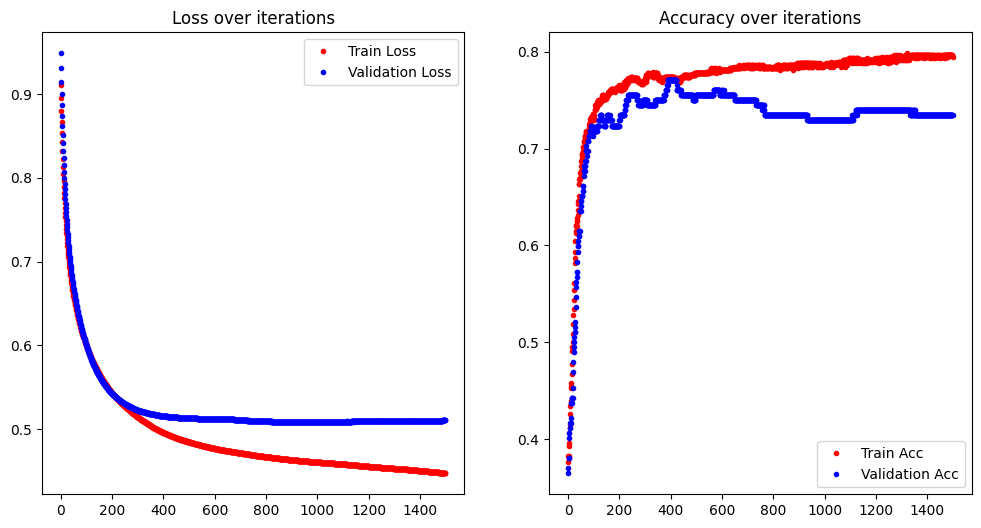

In [107]:
n = len(run_hist_2.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (run_hist_2.history["loss"]),'r.', label="Train Loss")
ax.plot(range(n), (run_hist_2.history["val_loss"]),'b.', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (run_hist_2.history["accuracy"]),'r.', label="Train Acc")
ax.plot(range(n), (run_hist_2.history["val_accuracy"]),'b.', label="Validation Acc")
ax.legend(loc='lower right')
ax.set_title('Accuracy over iterations')

6/6 [==============================] - 0s 2ms/step

accuracy is 0.641
roc-auc is 0.801


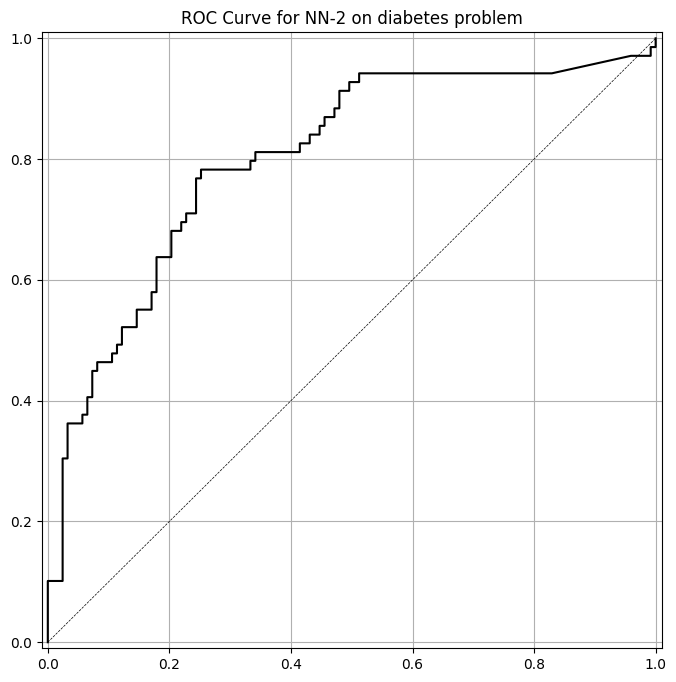

In [108]:
# Make predictions on test data
y_pred_prob_nn_2 = model_2.predict(X_test_norm)

# Obtain predicted class labels by taking the index of the highest probability for each example
y_pred_class_nn_2 = y_pred_prob_nn_2.argmax(axis=-1)

print('')
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_2)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_2)))

plot_roc(y_test, y_pred_prob_nn_2, 'NN-2')

## Authors


[Moazzam Ali](https://www.linkedin.com/in/moazzam-ali-6a9675237/) is a Associate ML Engineer and CEO of [MT Learners](https://www.linkedin.com/company/mt-learners/).
